In [1]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import sys
sys.path.append("/home/rufael.marew/Documents/projects/tau/Fingers-Gesture-Recognition")
import Source.fgr.models as models
from Source.fgr.pipelines import Data_Pipeline
from Source.fgr.data_manager import Data_Manager

import torch
from torch import nn
import torch.nn.functional as functional

from sklearn.manifold import TSNE
import seaborn as sns




/home/rufael.marew/.conda/envs/tau/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# pipeline definition and data manager creation
data_path = Path('../data/doi_10')
pipeline = Data_Pipeline(base_data_files_path=data_path)  # configure the data pipeline you would like to use (check pipelines module for more info)
subject = 1
dm = Data_Manager([subject], pipeline)
print(dm.data_info())

dataset = dm.get_dataset(experiments=[f'{subject:03d}_*_1'])
data = dataset[0]
labels = dataset[1]

labels = np.char.strip(labels, '_0123456789')
data = data.reshape(data.shape[0],4,4)

Available experiments in the data manager: ['001_1_3', '001_1_2', '001_2_1', '001_1_1', '001_2_2', '001_2_3']
Experiments format is: subject_session_position
None
Experiments in datasets: ['001_2_1', '001_1_1']
Starting to extract datasets


Loading experiments datasets:   0%|          | 0/2 [00:00<?, ?exp/s]

Error: annotation mismatch, no Release/End annotation for Recording ed in time: 0.904, in the experiment: 001_2_1


Loading experiments datasets:  50%|█████     | 1/2 [00:14<00:14, 14.01s/exp]

Error: annotation mismatch, no Release/End annotation for Recording ed in time: 0.862, in the experiment: 001_1_1


Loading experiments datasets: 100%|██████████| 2/2 [00:22<00:00, 11.02s/exp]

finished extracting the dataset


[533, 616, 665, 504, 549, 640, 536, 446, 636, 518]


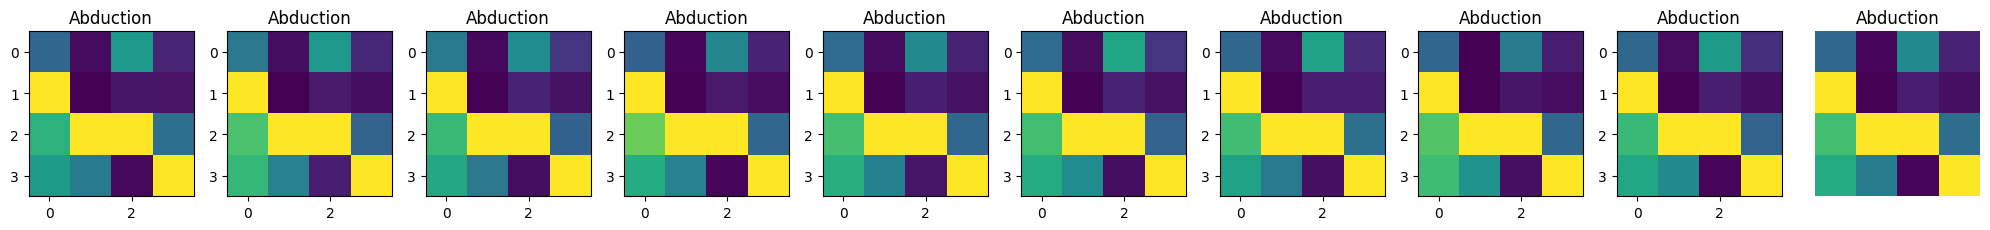

[925, 963, 884, 960, 907, 1033, 1034, 900, 1164, 1139]


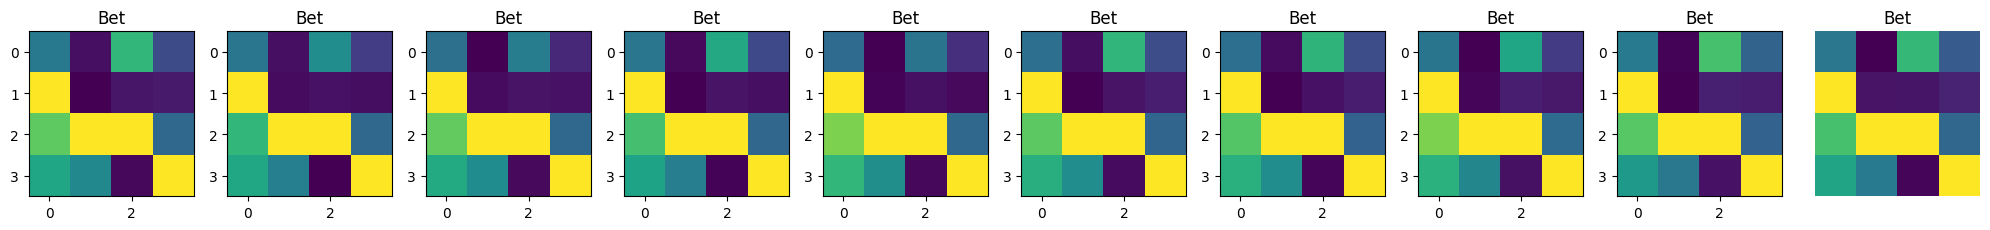

[803, 839, 758, 700, 754, 813, 754, 776, 797, 806]


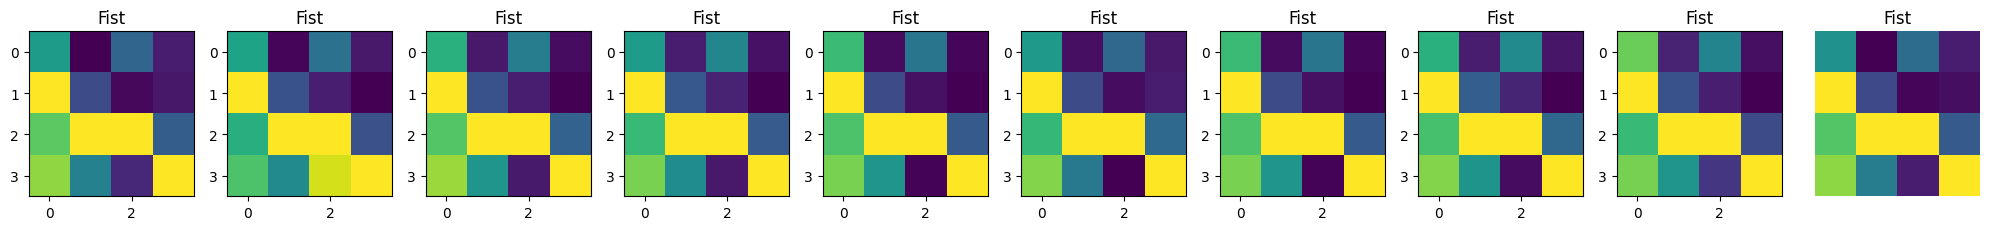

[1405, 1369, 1421, 1379, 1325, 1380, 1352, 1191, 1294, 1424]


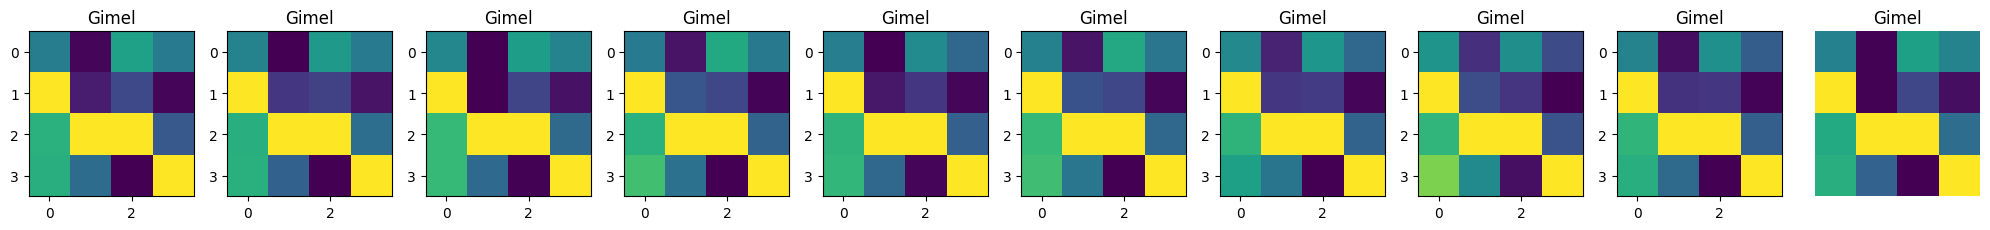

[1450, 1580, 1498, 1592, 1457, 1505, 1497, 1583, 1577, 1562]


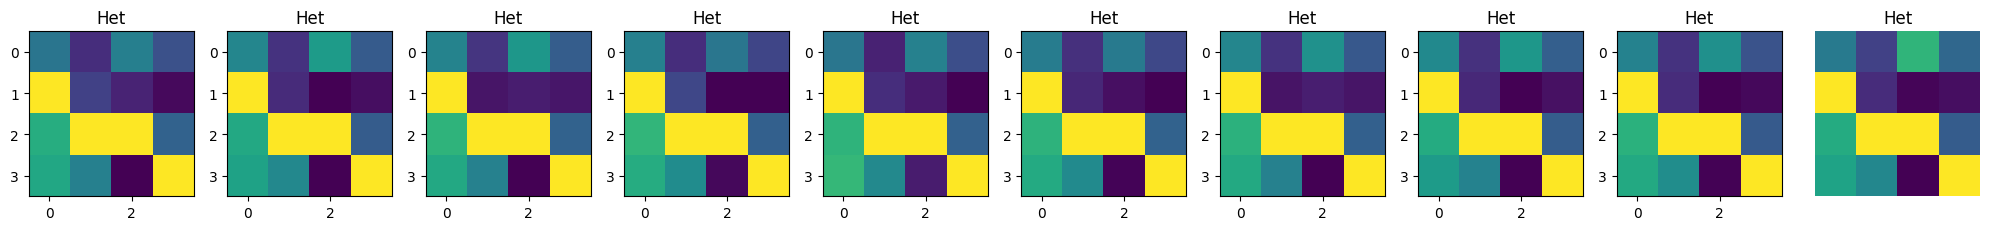

[2171, 1982, 2209, 1953, 2090, 2085, 2166, 1956, 1973, 2142]


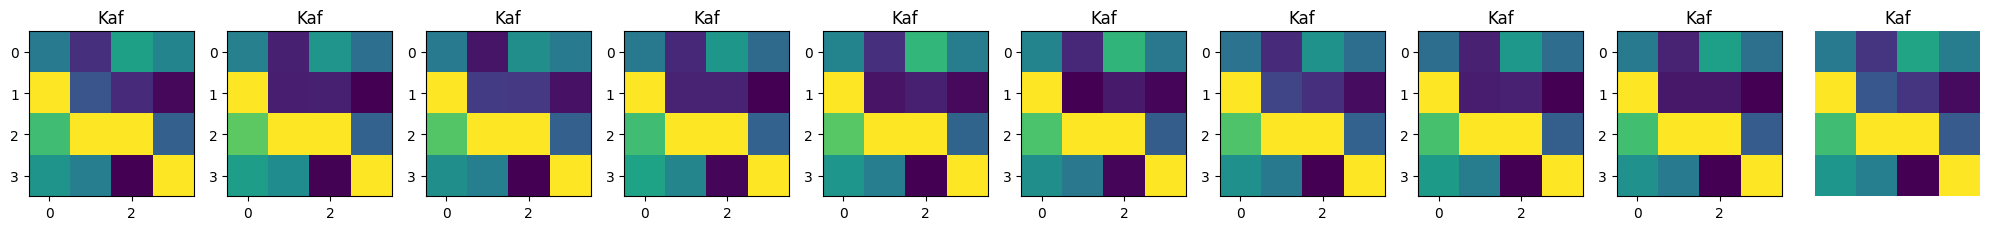

[2272, 2280, 2330, 2274, 2357, 2447, 2281, 2238, 2256, 2309]


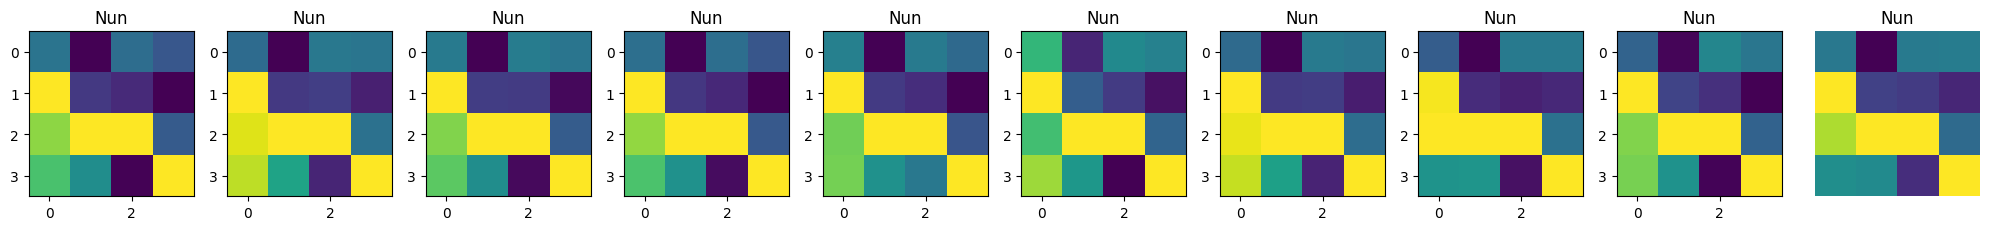

[1909, 1763, 1773, 1882, 1871, 1778, 1801, 1744, 1694, 1783]


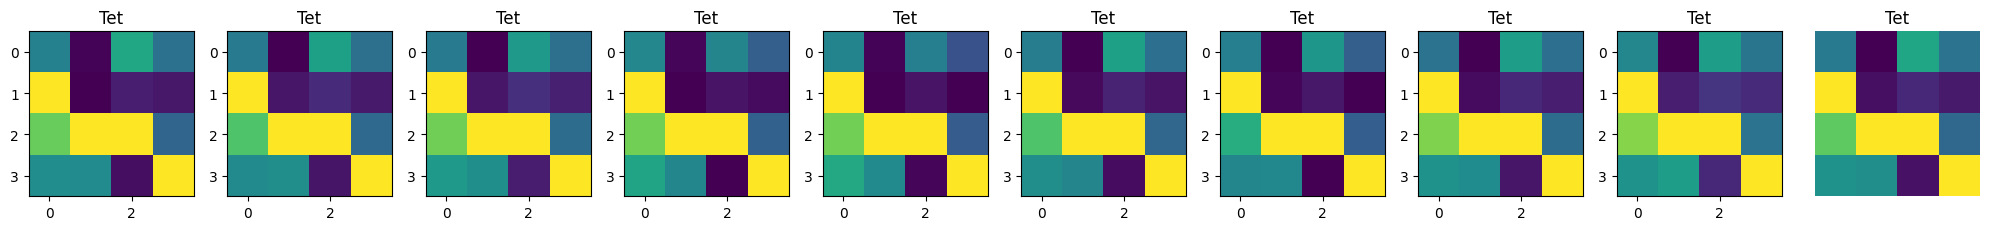

[295, 385, 348, 371, 385, 439, 233, 408, 320, 407]


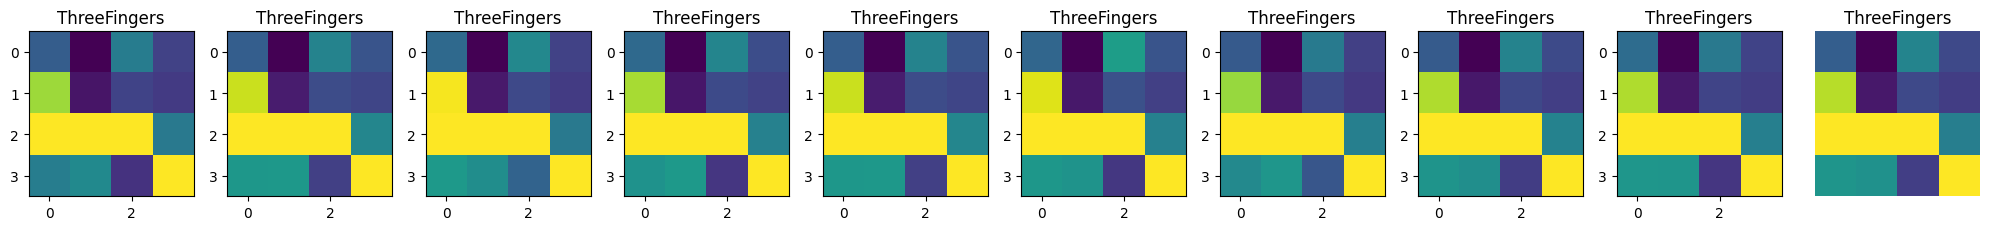

[128, 38, 174, 5, 23, 46, 129, 197, 107, 60]


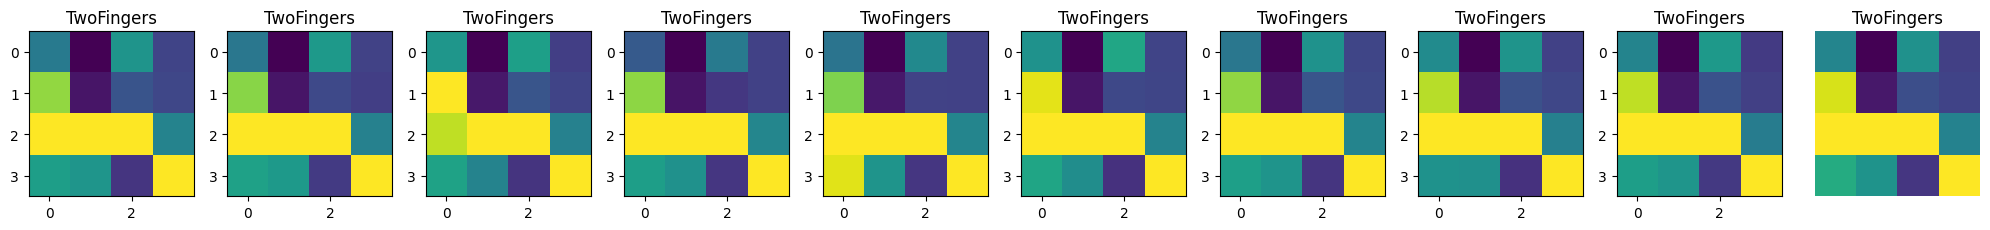

In [4]:
from random import randint, choices
# visualize 10 images from each class

for i in np.unique(labels):
    sample = choices([j for j in range(len(labels)) if labels[j] == i], k=10)
    print(sample)
    #create figure with subplots with figsize
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))    
    for index, k in enumerate(sample):
        axes[index].imshow(data[k])
        axes[index].set_title(labels[k])
    
    #remove axis
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

In [2]:
# pipeline definition and data manager creation
data_path = Path('../data/doi_10')
pipeline = Data_Pipeline(base_data_files_path=data_path)  # configure the data pipeline you would like to use (check pipelines module for more info)
subject = [1,4,5]
dm = Data_Manager(subject, pipeline)
# print(dm.data_info())
# data_pos = []
# for i in range(1,4):
#     dataset = dm.get_dataset(experiments=[f'{subject:03d}_1_{i}'])
#     data_pos.append(dataset[0])

# dataset = dm.get_dataset(experiments=[f'{subject:03d}_1_2'])

# data = dataset[0].reshape(dataset[0].shape[0],4,4)
# labels_pos = np.array([i.split('_')[2] for i in dataset[1]])
# labels_gest = np.array([i.split('_')[3] for i in dataset[1]])

In [21]:
class emgData:
    def __init__(self, data_manager, subjects):
        self.dm = data_manager
        self.subject = subjects

    def get_data_by_subject(self, subject, pos=1):
        data = []
        label_pos = []
        label_gest = []
        label_subject = []
        for i in subject:
            dataset = self.dm.get_dataset(experiments=[f'{i:03d}_*_{pos}'])
            data.append(dataset[0].reshape(dataset[0].shape[0],4,4))
            label_pos.append( np.array([i.split('_')[2] for i in dataset[1]]))
            label_gest.append(np.array([i.split('_')[3] for i in dataset[1]]))
            label_subject.append(np.array([str(i) for n in range(len(dataset[1]))]))
        return np.concatenate(data, axis=0), np.concatenate(label_pos, axis=0), np.concatenate(label_gest, axis=0), np.concatenate(label_subject, axis=0)

    
    def get_data_by_pos(self, pos, subject):
        data = []
        label_pos = []
        label_gest = []
        label_subject = []
        for i in pos:
            dataset = self.dm.get_dataset(experiments=[f'{subject:03d}_*_{i}'])
            data.append(dataset[0].reshape(dataset[0].shape[0],4,4))
            label_pos.append( np.array([i.split('_')[2] for i in dataset[1]]))
            label_gest.append(np.array([i.split('_')[3] for i in dataset[1]]))
            label_subject.append(np.array([subject for j in range(len(dataset[1]))]))

        return np.concatenate(data, axis=0), np.concatenate(label_pos, axis=0), np.concatenate(label_gest, axis=0), np.concatenate(label_subject, axis=0)

In [22]:
def extract_feat(data, model=None):
    if model == None:
        features = data.reshape(data.shape[0], 16)
        return features

    data = torch.from_numpy(data).float()
    data = data.reshape(data.shape[0], 1, 4, 4)
    features = model(data, feat=True)
    
    return features.detach().numpy()

In [23]:
def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(features)

    target_ids = range(len(np.unique(labels)))
    target_names = np.unique(labels)
    colors = sns.color_palette("hls", len(target_names))

    plt.figure(figsize=(6, 5))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(X_2d[labels == label, 0], X_2d[labels == label, 1], c=c, label=label)
    plt.legend()
    plt.title(title)
    plt.show()

In [24]:
emgdata = emgData(dm, [1,4,5])
data, label_pos, labels_gest, label_sub = emgdata.get_data_by_subject([1,4,5], 1)

Experiments in datasets: ['001_2_1', '001_1_1']
Starting to extract datasets


Loading experiments datasets: 100%|██████████| 2/2 [00:00<00:00, 121.17exp/s]


finished extracting the dataset
Experiments in datasets: ['004_1_1', '004_2_1']
Starting to extract datasets


Loading experiments datasets: 100%|██████████| 2/2 [00:00<00:00, 339.43exp/s]


finished extracting the dataset
Experiments in datasets: ['005_1_1', '005_2_1']
Starting to extract datasets


Loading experiments datasets: 100%|██████████| 2/2 [00:00<00:00, 318.86exp/s]

finished extracting the dataset


/tmp/ipykernel_306445/1035388985.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[labels == label, 0], X_2d[labels == label, 1], c=c, label=label)


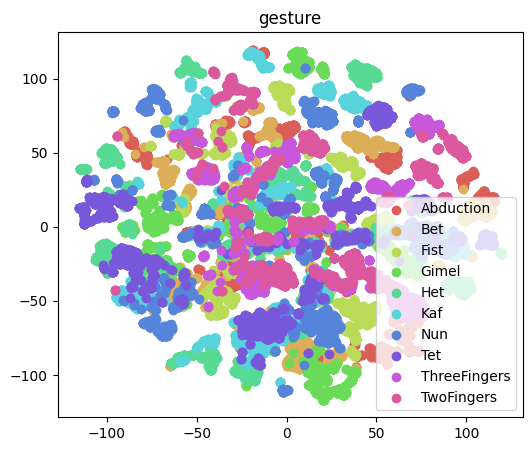

In [26]:
features = extract_feat(data)
plot_tsne(features, labels_gest, 'gesture')

In [25]:
label_sub

array(['1', '1', '1', ..., '5', '5', '5'], dtype='<U1')

/tmp/ipykernel_306445/1035388985.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_2d[labels == label, 0], X_2d[labels == label, 1], c=c, label=label)


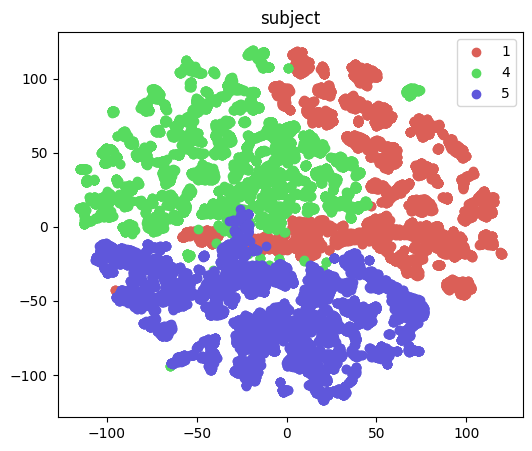

In [27]:
plot_tsne(features, label_sub,"subject")

In [29]:
ALGORITHMS = [
    'ERM',
    'Fish',
    'IRM',
    'GroupDRO',
    'Mixup',
    'MLDG',
    'CORAL',
    'MMD',
    'DANN',
    'CDANN',
    'MTL',
    'SagNet',
    'ARM',
    'VREx',
    'RSC',
    'SD',
    'ANDMask',
    'SANDMask',
    'IGA',
    'SelfReg',
    "Fishr",
    'TRM',
    'IB_ERM',
    'IB_IRM',
    'CAD',
    'CondCAD',
    'Transfer',
    'CausIRL_CORAL',
    'CausIRL_MMD',
    'EQRM',
]

' '.join(ALGORITHMS)

'ERM Fish IRM GroupDRO Mixup MLDG CORAL MMD DANN CDANN MTL SagNet ARM VREx RSC SD ANDMask SANDMask IGA SelfReg Fishr TRM IB_ERM IB_IRM CAD CondCAD Transfer CausIRL_CORAL CausIRL_MMD EQRM'